In [4]:
import numpy as np
from numpy import exp, pi, cos, sqrt, arccos
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
class CubicSpline:
    def __init__(self, x_nodes, y_nodes, alpha, beta):
        self._y = y_nodes
        self.x_nodes = x_nodes
        h = np.hstack((0, np.diff(x_nodes))) #10
        n = len(x_nodes)
        y = y_nodes

        A = np.zeros((n-2, n))
        for i in range(1, n-1):
            A[i-1, i-1] = h[i]
            A[i-1, i] = 2*(h[i]+h[i+1])
            A[i-1, i+1] = h[i+1]
        A = A[:, 1:-1]

        B = np.zeros((n-2, 1))    
        for i in range(1, n-1):
            B[i-1] = 6 * ((y[i+1] - y[i]) / h[i+1] - (y[i] - y[i-1]) / h[i])
 
        c = self.solve(A, B)
        cn = 1/h[-1] * (6 * ((y[-1] - y[-2]) / h[-1] - (y[-2] - y[-3]) / h[-2]) - c[-3]*h[-2] - 2*(h[-2] + h[-1])*c[-2])
        c = np.vstack((0, c, cn))

        d = np.zeros_like(c)
        for i in range(1, n-1):
            d[i] = (c[i] - c[i-1]) / h[i] 

        b = np.zeros_like(c)
        for i in range(1, n-1):
            b[i] = (y[i] - y[i-1]) / h[i] + (c[i] * h[i] / 2) - (d[i] * h[i] * h[i] / 6)
        
        a, b, c, d = y, b.T[0], c.T[0], d.T[0]
        
        b[0] = alpha
        b[-1] = beta

        d[-1] = (c[-1] - c[-2]) / h[-1]

        self.a, self.b, self.c, self.d = a, b, c, d
        self.h = h

    def _count(self, x):
        for i in range(1, len(self.x_nodes)):
            if self.x_nodes[i-1] <= x < self.x_nodes[i]:
                return self.a[i] + self.b[i]*(x-self.x_nodes[i]) +  self.c[i]*(x-self.x_nodes[i])**2 / 2 + self.d[i]*(x-self.x_nodes[i])**3 / 6

    def __call__(self, x_array):
        try:
            iter(x_array)
            y_array = np.zeros_like(x_array)
            for i, x in enumerate(x_array):
                y_array[i] = self._count(x)
            return y_array
        except:
            return self._count(x_array)

    @staticmethod
    def solve(A, B):
        C = np.hstack((A, B.reshape(-1, 1)))
        
        for i in range(len(C)-1):
            i_max = np.argmax(abs(C[i:, i])) + i
            C[[i, i_max]] = C[[i_max, i]]
            for row in range(i+1, len(C)):
                C[row, :] -= C[i, :] / C[i, i] * C[row, i]

        X = np.zeros_like(B)
        for i, m in enumerate(C[::-1]):
            m = m[-i-2:]
            X[-(i+1)] = (m[-1] - m[-2: 0: -1] @ X[-1: -1-i: -1]) / m[0]

        return X

In [6]:
def chebyshov_roots(a, b, n):
    return np.array([(b + a)/2 + (b - a)/2 * cos((2*m + 1)/(2*n)*pi) for m in range(n)][::-1])

In [7]:
f = lambda x: arccos(x) + x
f_der = lambda x: - 1 / sqrt(1 - x**2) + 1
a, b = -0.9, 0.9
x_control = 0.8
print(f_der(a), f_der(b))

-1.294157338705618 -1.294157338705618


In [8]:
x_nodes = chebyshov_roots(a, b, 10)
y_nodes = f(x_nodes)
print(x_nodes)

[-0.88891951 -0.80190587 -0.6363961  -0.40859145 -0.14079102  0.14079102
  0.40859145  0.6363961   0.80190587  0.88891951]


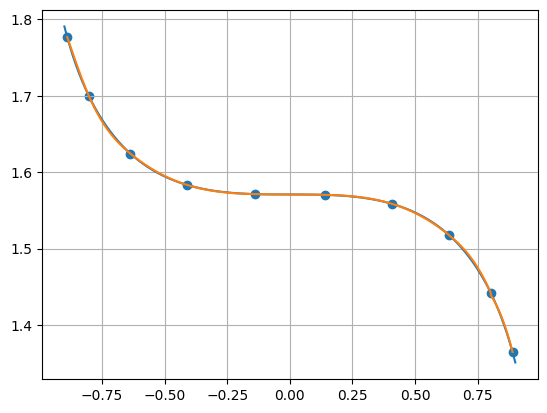

,a,b,c,d,h
0,1.776858,-1.294157,0.000000,0.000000,0.000000
1,1.699369,-0.748557,4.895098,56.256680,0.087014
2,1.624217,-0.270164,0.885747,-24.224254,0.165510
3,1.583115,-0.101843,0.592012,-1.289417,0.227805
4,1.571266,-0.008327,0.106393,-1.813361,0.267800
5,1.570327,-0.008327,-0.106393,-0.755683,0.281582
6,1.558477,-0.101843,-0.592012,-1.813361,0.267800
7,1.517375,-0.270164,-0.885747,-1.289417,0.227805
8,1.442224,-0.748557,-4.895098,-24.224254,0.165510
9,1.364735,-1.294157,-12.528117,-87.722105,0.087014


In [9]:
s = CubicSpline(x_nodes, y_nodes, f_der(a), f_der(b))
x = np.linspace(a, b, 10000)
plt.plot(x, f(x))
plt.plot(x, s(x))

plt.scatter(x_nodes, f(x_nodes))
plt.grid()
plt.show()
pd.DataFrame({'a': s.a, 'b': s.b, 'c': s.c, 'd': s.d, 'h': s.h})

In [29]:
s = CubicSpline(x_nodes, y_nodes, f_der(a), f_der(b))

array([[ 2.61885357],
       [ 1.64180426],
       [ 0.81707821],
       [ 0.24548401],
       [-0.24548401],
       [-0.81707821],
       [-1.64180426],
       [-2.61885357]])

In [137]:
print(s(x_nodes[4]), y_nodes[4])
print(s(x_nodes[5]), y_nodes[5])
print(s(x_nodes[4] - 0.01))
print(s(x_nodes[5]-0.01))

-1.6327065617036187 0.9386342665136536
-0.6052773280171428 6.4064062175597165
0.8875404736079672
6.208261006594427


In [150]:
from scipy import interpolate
import scipy
spline = interpolate.CubicSpline(x_nodes, y_nodes)

print(scipy.signal.cspline1d(x_nodes, y_nodes))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
    # @classmethod
    # def solve_system(self, A, b):
        # n = len(A)
        # A = np.array(A, 'float')
        # # b = np.array(b, 'float')
        # # b.shape = -1, 1
        # L = self.cholesky(A).T
        # #A_ext = np.hstack((A, b))
        # y = np.zeros(n)
        # x = np.zeros(n)

        # #y[0] = A_ext[0, -1] / L[0, 0]
        # y[0] = b[-1] / L[0, 0]
        # for i in range(1, n):
        #     #y[i] = (A_ext[i, -1] - sum([L[k, i]*y[k] for k in range(i)])) / L[i, i]
        #     y[i] = (b[i] - sum([L[k, i]*y[k] for k in range(i)])) / L[i, i]

        # x[-1] = y[-1] / L[-1, -1]
        # for i in range(n):
        #     x[i] = (y[i] - sum([L[i, k]*x[k] for k in range(i+1, n)])) / L[i, i]
        # return x

    # def _find_L(self, A):
    #     L = np.zeros_like(A)
    #     L[0, 0] = sqrt(A[0, 0])
    #     L[0, :] = A[0, :] / L[0, 0]
    #     for i in range(self._n):
    #         L[i, i] = sqrt(A[i, i] - sum([L[k, i]**2 for k in range(i)]))
    #     for i in range(self._n):
    #         for j in range(i):
    #             L[i, j] 
    
    # @staticmethod
    # def cholesky(matrix):
    #     C = np.zeros_like(matrix, 'float')
    #     for i in range(C.shape[0]):
    #         for j in range(i+1):
    #             s = sum(C[i][k] * C[j][k] for k in range(j))
    #             C[i][j] = sqrt(matrix[i][i] - s) if (i == j) else \
    #                     (1.0 / C[j][j] * (matrix[i][j] - s))
    #     return C

    # def square_root_method(self, A, b):
    #     L = self.choleskiy(A)
    #     U = L.T

    # def __call__(self, x_array):
    #     result = []
    #     x_array = np.array(x_array)
    #     for x in x_array:
    #         result.append(self._count_y(x))
    #     return np.array(result)

In [ ]:
class CubicSpline:
    def __init__(self, x_nodes, y_nodes, alpha, beta):
        self._y = y_nodes
        self.x_nodes = x_nodes
        h = np.hstack((0, np.diff(x_nodes))) #10
        n = len(x_nodes)
        y = y_nodes

        A = np.zeros((n-2, n)) #A размерностью 8 на 10
        for i in range(1, n-1):
            A[i-1, i-1] = h[i]
            A[i-1, i] = 2*(h[i]+h[i+1])
            A[i-1, i+1] = h[i+1]
        A = A[:, 1:-1] # обрубаем первый и последний столбцы

        B = np.zeros((n-2, 1))    
        for i in range(1, n-1):
            B[i-1] = 6 * ((y[i+1] - y[i]) / h[i+1] - (y[i] - y[i-1]) / h[i])

        c = solve(A, B) #с = [c1, ..., cn-1]
        cn = 1/h[-1] * (6 * ((y[-1] - y[-2]) / h[-1] - (y[-2] - y[-3]) / h[-2]) - c[-3]*h[-2] - 2*(h[-2] + h[-1])*c[-2])
        c = np.vstack((c, cn)) #c = [c0, ..., cn]

        d = np.zeros_like(c)
        for i in range(1, n-1):
            d[i] = 2*(c[i] - c[i-1]) / h[i+1] #d2, ..., dn-1
            #двойку добавил
            #Индекс у h был i
        #d = [0, d2, ..., dn-1]

        b = np.zeros_like(c)
        for i in range(1, n-1):
            b[i] = (y[i] - y[i-1]) / h[i] + (c[i] * h[i] / 2) + (d[i] * h[i] * h[i] / 6)
            #b[i] = 6 * (y[i] - y[i-1]) / h[i] + (2*c[i] + c[i-1])*h[i]
        #b = [0, b2, ..., bn-1]

        b = np.vstack((alpha, b))
        b[-1] = beta
        c = np.vstack((0, c))
        d = np.vstack((0, d))

        b[1] = (y[1] - y[0]) / h[1] + c[1] * h[1] / 2 + d[1] * h[1]**2 / 6
        
        d[1] = 6 * (y[1]-y[0]) / h[1]**3 + 3*c[1]/h[1] - 6*b[1]/h[1]**2

        d[-1] = (c[-1] - c[-2]) / h[-1]

        a = y.reshape(-1, 1)

        self.a, self.b, self.c, self.d = a.T[0], b.T[0], c.T[0], d.T[0]
        self.h = h

    def __call__(self, x_array):
        try:
            iter(x_array)
            y_array = np.zeros_like(x_array)
            for j, x in enumerate(x_array):
                for i in range(1, len(self.x_nodes)):
                    if self.x_nodes[i-1] <= x <= self.x_nodes[i]:
                        y_array[j] = self.a[i] + self.b[i]*(x-self.x_nodes[i]) +  self.c[i]*(x-self.x_nodes[i])**2 / 2 + self.d[i]*(x-self.x_nodes[i])**3 / 6
            return y_array
        except:
            x = x_array
            for i in range(1, len(self.x_nodes)):
                if self.x_nodes[i-1] <= x <= self.x_nodes[i]:
                    y = self.a[i] + self.b[i]*(x-self.x_nodes[i]) + self.c[i]*(x-self.x_nodes[i])**2 / 2 + self.d[i]*(x-self.x_nodes[i])**3 / 6
            return y

In [29]:
0.6832 - 0.6744

0.00880000000000003

In [ ]:
class CubicSpline:
    def __init__(self, x_nodes, y_nodes, alpha, beta):
        self._y = y_nodes
        self._x = x_nodes
        h = np.hstack((0, np.diff(x_nodes)))
        n = len(x_nodes)
        y = y_nodes

        A = np.zeros((n-2, n))
        for i in range(1, n-1):
            A[i-1, i-1] = h[i]
            A[i-1, i] = 2*(h[i]+h[i+1])
            A[i-1, i+1] = h[i+1]
        A = A[:, 1:-1]

        B = np.zeros((n-2, 1))    
        for i in range(1, n-1):
            B[i-1] = 6 * (y[i+1] - y[i]) / h[i+1] - (y[i] - y[i-1]) / h[i]

        c = solve(A, B) #c1, ..., cn-1
        print(c)

        d = np.zeros_like(c)
        for i in range(1, n-1):
            d[i] = (c[i] - c[i-1]) / h[i] #d2, ..., dn-1
        print(d)
        
        b = np.zeros_like(c)
        for i in range(1, n-1):
            b[i] = (y[i] - y[i-1]) / h[i] + c[i] * h[i] / 2 + d[i] * h[i]**2 / 6
        b = np.vstack((alpha, b, beta))
        


        



    @property
    def n(self):
        return len(self._h) + 1

    @property
    def A(self):
        h = self._h
        n = self.n
        A = np.zeros((n-2, n))
        for i in range(1, n-1):
            A[i-1, i-1] = h[i-1]
            A[i-1, i] = 2*(h[i-1]+h[i])
            A[i-1, i+1] = h[i]
        return A[:, 1:-1]

    @property
    def B(self):
        n = self.n
        b = np.zeros((n-2, 1))
        y = self._y
        h = self._h

        for i in range(1, n-1):
            b[i-1] = 6 * (y[i+1] - y[i]) / h[i] - (y[i] - y[i-1]) / h[i-1]
        return b

    @property
    def c(self):
        return np.vstack((0, solve(self.A, self.B)))

    @property
    def d(self):
        c = np.vstack((0, self.c, 0))
        n = self.n
        d = np.zeros((n, 1))
        h = self._h

        for i in range(1, n):
            d[i] = (c[i] - c[i-1]) / h[i-1]

        return d[1:]
    
    @property
    def b(self):
        n = self.n
        b = np.zeros((n, 1))
        y = self._y
        h = self._h
        c = self.c
        d = self.d

        for i in range(1, n-1):
            b[i] = (y[i] - y[i-1]) / h[i-1] + c[i] * h[i-1] / 2 + d[i] * h[i-1]**2 / 6
        b = b[:-1]
        b[0] = self._alpha
        b[-1] = self._beta
        return b
    
    @property
    def a(self):
        return self._y

    def __call__(self, x):
        x = np.array(x)
        y = np.zeros_like(x)
        a, b, c, d = self.a, self.b, self.c, self.d
        x_nodes = self.x
        for i in range(len(a)):
            if x_nodes[i] <= x < x_nodes[i+1]:
                x.append
            
            



    def get_A(self):
        return self._A

In [21]:
eps = 1e-10    # погрешность

# Функция вывода матрицы на экран
def displayArray(info ,a):
    print(info)
    n = len(a)
    for i in range(n):
        line = ""
        for j in range(n + 1):
            line += str("%10.5f" % a[i][j]) + "      "
            if j == n - 1:
                line += "| "
        print(line)
    print("")


# Функция вывода матрицы на экран
def displayArray2(info ,a):
    print(info)
    n = len(a)
    for i in range(n):
        line = ""
        for j in range(n):
            line += str("%10.5f" % a[i][j]) + "      "
        print(line)
    print("")


# Функция вывод решения на экран
def displaySolution(x):
    print("Решение системы:")
    for i, val in enumerate(x):
        print("x%x" % (i + 1), " = %5.5f" % val)


# Функция вывода умножения матриц на экран
def displayVec(info, r):
    print(info)
    n = len(r)
    for i in range(n):
        print("%5.5f" % r[i], end="    ")
    print("")


# Нахождение максимально элемента в строке
def maxelement(a, col, count_swap):
    n = len(a)
    maxel = a[col][col]
    maxrow = col
    for i in range(col + 1, n):
        if maxel < abs(a[i][col]):
            maxel = abs(a[i][col])
            maxrow = i
    if col != maxrow:
        swap(a, maxrow, col)
        count_swap += 1
    return count_swap


# Проверка на ноль
def checkByZero(q):
    if abs(q) < eps:
       return 1


# Вычисление определителя
def determinant(a, count_swap):
    det = 1
    n = len(a)
    if count_swap % 2:
        count_swap = -1
    else:
        count_swap = 1
    for i in range(n):
        det *= a[i][i]
    det *= count_swap
    return det


# Перестановка строк
def swap(a, row_one, row_two=0):
    n = len(a)
    for i in range(n + 1):
        tmp = a[row_one][i]
        a[row_one][i] = a[row_two][i]
        a[row_two][i] = tmp



# Вычетание строк
def sub(a, row_one, row_two, mn=1):
    n = len(a)
    for i in range(n + 1):
        a[row_one][i] -= a[row_two][i] * mn
    return a


# Приведение к треугольной матрице
def triangle(a):
    n = len(a)
    count_swap = 0
    for j in range(n):
        count_swap = maxelement(a, j, count_swap)
        for i in range(j + 1, n):
            c = a[i][j] / a[j][j]
            sub(a, i, j, c)
    return count_swap


# Нахождение решение, методом обратного хода
def searchSolution(a):
    n = len(a)
    solution = [0 for i in range(n)]
    for i in range(n - 1, -1, -1):
        solution[i] = a[i][n] / a[i][i]
        for j in range(i - 1, -1, -1):
            a[j][n] -= a[j][i] * solution[i]
    return solution


# Метод Гаусса
def gauss(a):
    count_swap = triangle(a)
    det = determinant(a, count_swap)
    flag = checkByZero(det)
    if flag:
        print("\nМатрица вырожденная. Определитель равен нулю\n")
        exit(1)
    x = searchSolution(a)
    return x


# Умножение матриц
def matrix_mul(a, x):
    n = len(a)
    m = len(x)
    result = []
    for i in range(n):
        s = 0
        for j in range(m):
            s += x[j] * a[i][j]
        result.append(s)
    return result


# Умножение матриц 2
def matrix_mul_2(a, b):
    n = len(a)
    res = [[0 for i in range(n)] for j in range(n)]
    for i in range(n):
        for j in range(n):
            for k in range(n):
                res[i][j] += a[i][k] * b[k][j]
    return res

# Выделение матрицы B
def getVectorB(a):
    n = len(a)
    vectorB = []
    for i in range(n):
        vectorB.append(a[i][n])
    return vectorB

def getVectorA(a):
    vectorA = a[:]
    return vectorA

# Нахождение невязки
def discrepancy(res, b):
    for i in range(len(b)):
        res[i] = b[i] - res[i]
    return res


# Обратная матрица
def inverse(a):
    n = len(a)
    inv = [[0 for i in range(len(a) + 1)] for j in range(len(a))]
    for i in range(n):
        for j in range(n):
            if i == j:
                a[j][n] = 1.0
            else:
                a[j][n] = 0.0
        q = copy.deepcopy(a)
        vec_sol = gauss(q)
        for k in range(len(vec_sol)):
            inv[k][i] = vec_sol[k]
    return inv


# Вычисление нормы
def norm(a):
    n = len(a)
    max = 0
    for i in range(n):
        sum = 0
        for j in range(n):
            sum += abs(a[i][j])
            if max < sum:
                max = sum
    return max


# Число обусловленности матрицы
def condition_number(norm_one, norm_two):
    cond = norm_one * norm_two
    return cond

if __name__ == "__main__":
    import numpy, copy

    arr =[[7, 8, 6],
        [5, 10, 3],
        [1,-6, 4]]
        
    clean_arr = copy.deepcopy(arr)


    displayArray("Начальная матрица", arr)


    # Метод Гаусса
    count_swap = triangle(arr)
    displayArray("Треугольная матрица", arr)
    det = determinant(arr, count_swap)
    flag = checkByZero(det)
    if flag:
        print("\nМатрица вырожденная. Определитель равен нулю\n")
        exit(1)
    print("Определитель: %5.5f" % det)
    x = searchSolution(arr)
    displaySolution(x)

    # Нахождение невязки
    b = getVectorB(clean_arr)
    displayVec("Вектор B:", b)
    res = matrix_mul(clean_arr, x)
    displayVec("Результат перемножения матрицы A на вектор решения X:", res)
    dis = discrepancy(res, b)
    displayVec("Невязка:", dis)

    # Нахождение обратной матрицы
    inv = inverse(clean_arr)
    displayArray2("Обратная матрица", inv)

    # Нахождение числа обусловленности матрицы
    a = getVectorA(clean_arr)
    displayArray2("Матрица A", a)
    norm_a = norm(clean_arr)
    print("Норма А: ", norm_a, end="")
    norm_inv = norm(inv)
    print("\nНорма обратной матрицы: ", norm_inv, end="")
    cond = condition_number(norm_a, norm_inv)
    print("\nЧисло обусловленности матрицы: ", cond, end="")


Начальная матрица


IndexError: list index out of range